In [1]:
import pandas as pd
import numpy as np

import re
import nltk

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from gensim.models import *
from gensim import corpora

from tqdm.notebook import tqdm

In [2]:
col_names = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 'tfoll', 'tfrien', 'listcount']

In [3]:
positive_df = pd.read_csv('positive.csv', sep=';', header=None, index_col=0, names=col_names, encoding='utf-8')
positive_df.head()

,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
id,,,,,,,,,,,
408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [4]:
negative_df = pd.read_csv('negative.csv', sep=';', header=None, index_col=0, names=col_names, encoding='utf-8')
negative_df.head()

,tdate,tmane,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
id,,,,,,,,,,,
408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [5]:
combine_df = positive_df.iloc[:, 2].append(negative_df.iloc[:, 2], ignore_index=True)
combine_df = combine_df.dropna().drop_duplicates()
combine_df.head()

0    @first_timee хоть я и школота, но поверь, у на...
1    Да, все-таки он немного похож на него. Но мой ...
2    RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3    RT @digger2912: "Кто то в углу сидит и погибае...
4    @irina_dyshkant Вот что значит страшилка :D\nН...
Name: ttext, dtype: object

### 1. Предобработка

In [6]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
morpher = MorphAnalyzer()
sw_ru = set(get_stop_words("ru"))

In [7]:
#1. избавимся от букв латинского алфавита, чисел, знаков препинания и всех символов, например, символ @ встречается почти везде;
#2. разобьем пост на токены;
#3. проведем лемматизацияю, получив нормальную (начальную) форму слова;
#4. удалим стоп-слова и слова с длиной менее 3х символов.
def preprocess_txt(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in sw_ru:
            token = token.strip()
            token = morpher.normal_forms(token)[0]
            if len(token) > 2:
                tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [8]:
%%time
data = combine_df.apply(preprocess_txt)
data = data.dropna()

Wall time: 3min 36s


In [9]:
data[:5]

0    [школотый, поверь, самый, общество, профилиров...
1                      [таки, похожий, мальчик, равно]
3    [кто, угол, сидеть, погибать, голод, порция, в...
4    [вот, страшилка, блин, посмотреть, часть, созд...
5                                 [любить, знать, бля]
Name: ttext, dtype: object

### 2. Модель LDA

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [10]:
dictionary = corpora.Dictionary(data)

dictionary.filter_extremes(no_below=10,
                           no_above=0.9,
                           keep_n=None) #игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweets.dict')

Векторизуем документы:

In [11]:
corpus = [dictionary.doc2bow(text) for text in data]
corpora.MmCorpus.serialize('tweets.model', corpus)

Теперь можем обучать модель:

In [12]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

Wall time: 3min 48s


Посмотрим на получившиеся темы:

In [13]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(14,
  '0.372*"минута" + 0.347*"нравиться" + 0.082*"посидеть" + 0.064*"мужчина" + 0.007*"костюм" + 0.000*"пойти" + 0.000*"понимать" + 0.000*"что" + 0.000*"час" + 0.000*"ждать"'),
 (13,
  '0.284*"надеяться" + 0.230*"приехать" + 0.211*"родный" + 0.134*"москва" + 0.000*"родитель" + 0.000*"гость" + 0.000*"вообще" + 0.000*"дом" + 0.000*"игра" + 0.000*"жаль"'),
 (19,
  '0.431*"идти" + 0.185*"свой" + 0.106*"каждый" + 0.093*"капец" + 0.043*"там" + 0.040*"видимо" + 0.029*"радовать" + 0.023*"факт" + 0.000*"спать" + 0.000*"нахуй"'),
 (12,
  '0.409*"друг" + 0.336*"работа" + 0.108*"русский" + 0.032*"шутить" + 0.018*"возле" + 0.009*"мимими" + 0.000*"говорить" + 0.000*"жаль" + 0.000*"делать" + 0.000*"страна"'),
 (0,
  '0.235*"утро" + 0.179*"вчера" + 0.177*"прийти" + 0.172*"забыть" + 0.068*"добрый" + 0.060*"утром" + 0.049*"общаться" + 0.013*"похуй" + 0.000*"спать" + 0.000*"человек"'),
 (6,
  '0.718*"хотеть" + 0.154*"сидеть" + 0.042*"взять" + 0.033*"кто" + 0.030*"жрать" + 0.000*"спать" + 0.000*"дом" +

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки __pyLDAvis__. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [14]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Wall time: 14.6 s


### 3. Поиск оптимального числа тем

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

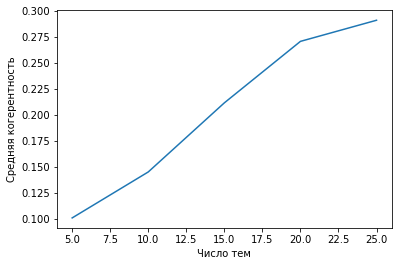

In [16]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [17]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 11 s


### 4. Интерпретация

В целом можно сделать выводы о близких тематиках всех текстов. Это темы связанные с бытовыми аспектами жизни авторов. Среди прочих отдельно выделяется тема связанная с учёбой в школе.